In [52]:
# Imports
import cv2 as cv
import math
import matplotlib.pyplot as plt
import numpy as np

In [53]:
# Variables
	# Load images
smarties_root = "./static/image/lecture_03"
smarties = [ cv.imread( f"{smarties_root}/smarties{i}.webp" ) for i in range( 1, 8 ) ]

In [54]:
# Methods
	# Image display
def display( image: np.ndarray ):
	plt.figure()

	if ( len( image.shape ) > 2 ) and ( image.shape[ 2 ] > 2 ):
		plt.imshow( cv.cvtColor( image, cv.COLOR_BGR2RGB ) )
	else:
		plt.imshow( image, cmap="gray" )

	# Image preparation
def scale_to_width( image: np.ndarray, width: int ):
	height = int( image.shape[ 0 ] * ( width / image.shape[ 1 ] ) )
	return cv.resize( image, ( width, height ), interpolation=cv.INTER_LINEAR_EXACT )

def artifact_denoise( image: np.ndarray, strength: int = 1 ):
	denoised = cv.fastNlMeansDenoisingColored( image, None, ( 2 * strength + 1 ), ( 2 * strength ) + 1 )
	return cv.bilateralFilter( denoised, ( 2 * strength ) + 1, ( 4 * strength ) + 11, ( 2 * strength ) + 7 )

	# Helpers
def get_mask( gray: np.ndarray ):
	cv.dilate( gray, np.ones( ( 3, 3 ) ), dst=gray )
	contours, _ = cv.findContours( gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE )
	mask = np.zeros( gray.shape[ 0 : 2 ], "uint8" )
	cv.drawContours( mask, contours, -1, 255, -1 )
	cv.medianBlur( mask, 3, dst=mask )

	return mask

	# Image manipulation
def threshold_hsv( image: np.ndarray, lower: list = [ 0, 0, 0 ], upper: list = [ 255, 255, 255 ] ):
	image = cv.cvtColor( image, cv.COLOR_BGR2HSV_FULL )
	mask = get_mask( cv.inRange( image, np.array( lower, "uint8" ), np.array( upper, "uint8" ) ) )
	image[ :, :, 2 ] &= mask
	
	cv.cvtColor( image, cv.COLOR_HSV2BGR_FULL, dst=image )
	return image

def extract_saturated( image: np.ndarray, q: float = 2.0, f: float = 0.5, min_value: int = 20 ):
	image = cv.cvtColor( image, cv.COLOR_BGR2HSV_FULL )
	hsv: tuple[ np.ndarray ] = cv.split( image )

	v_cond = ( hsv[ 2 ] >= min_value )

	s_mean = hsv[ 1 ].mean( where=v_cond )
	s_dev = hsv[ 1 ].std( where=v_cond ) * q
	s_min = hsv[ 1 ].min( where=( hsv[ 1 ] > s_mean - s_dev ), initial=255 )
	s_max = hsv[ 1 ].max( where=( hsv[ 1 ] < s_mean + s_dev ), initial=0 )
	s_thres = ( s_min + ( s_max - s_min ) * f )

	mask = hsv[ 2 ] * ( hsv[ 1 ] >= s_thres )
	image[ :, :, 2 ] &= mask

	cv.cvtColor( image, cv.COLOR_HSV2BGR_FULL, dst=image )

	return image

def sharpen( image: np.ndarray, x: int = 1 ):
	kernel = np.array( [
		[ 0, -x, 0 ],
		[ -x, ( 4 * x ) + 1, -x ],
		[ 0, -x, 0 ]
	] )

	return cv.filter2D( image, -1, kernel )

def erode( image: np.ndarray, x: int = 1, r: int = 1 ):
	kernel = np.ones( ( x, x ) )
	return cv.erode( image, kernel, iterations=r )
	
		

	
	

135


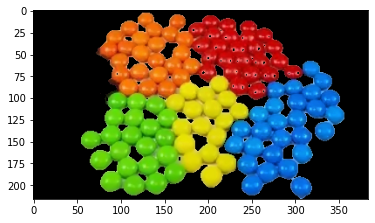

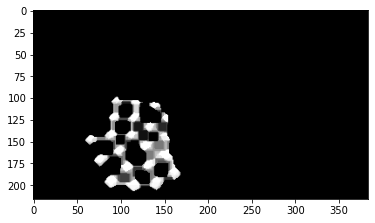

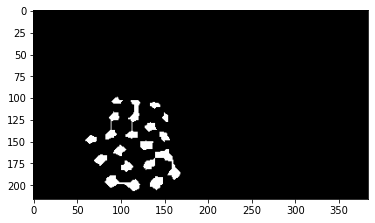

In [67]:
# Testing
image = smarties[ 1 ]

scaled = scale_to_width( image, 384 )
denoised = artifact_denoise( scaled, )
extracted = extract_saturated( denoised )
green = threshold_hsv( extracted, [ 64, 30, 20 ], [ 107, 255, 255 ] )

#green = sharpen( green, 8 )
gray = cv.cvtColor( green, cv.COLOR_BGR2GRAY )

# contours, _ = cv.findContours( gray, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE )
# cv.drawContours( gray, contours, -1, 0, 1 )

# cv.medianBlur( gray, 3, dst=gray )

#_, gray = cv.threshold( gray, 200, 0, cv.THRESH_TOZERO_INV )
# #cv.medianBlur( gray, 3, dst=gray )
#gray = sharpen( gray )
#cv.dilate( gray, np.ones( ( 2, 2 ) ), dst=gray )
#gray = erode( gray, 2, 6 )
#cv.dilate( gray, np.ones( ( 2, 2 ) ), dst=gray )


#gray = sharpen( gray, 2 )

# c, h = cv.findContours( gray, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE )
# cv.drawContours( extracted, c, -1, ( 255, 0, 255 ), 1 )
# gray = erode( gray, 2, 6 )
# cv.dilate( gray, np.ones( ( 2, 2 ) ), dst=gray )

gray = sharpen( gray, 2 )
gray_avg = gray.mean( where=( gray > 20 ) )
gray = np.clip( gray, 0, gray_avg - 20 ).astype( "uint8", copy=False )
print( gray.max() )
cv.medianBlur( gray, 3, dst=gray )
gray = erode( gray, 3, 4 )

gray_avg = gray.mean( where=( gray > 20 ) )
_, thres = cv.threshold( gray, gray_avg, 255, cv.THRESH_BINARY )

display( extracted )
display( gray )
display( thres )
